In [ ]:
#Install the following packages required to execute this notebook
!pip3 install google-cloud-aiplatform --user
!pip3 install pyarrow==11.0.0 --user
!pip3 install --upgrade google-cloud-bigquery --user
!pip3 install --upgrade google-cloud-bigquery-storage --user
!pip3 install --upgrade google-cloud-storage --user
!pip install db-dtypes

In [2]:
from google.cloud import bigquery
from google.cloud import aiplatform as vertexai
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics

In [3]:
# Retrieve and set PROJECT_ID environment variable
PROJECT_ID = !(gcloud config get-value core/project)
PROJECT_ID = PROJECT_ID[0]

In [4]:
# Set REGION environment variable
REGION = 'us-east4'
print(REGION)
BQ_LOCATION = 'US'

us-east4


In [5]:
# Create a storage bucket to serve as a staging bucket for Vertex AI.
GCS_BUCKET = f"{PROJECT_ID}-kavi_capstone_bucket"

In [ ]:
# Run this command only one time to create a storage bucket
#!gsutil mb -l $REGION gs://$GCS_BUCKET

In [8]:
# Next, create a BigQuery dataset from this notebook using the Python-based [`bq` command line utility](https://cloud.google.com/bigquery/docs/bq-command-line-tool). 
# This dataset will group your feature views, model, and predictions table together. You can view it in the [BigQuery](https://pantheon.corp.google.com/bigquery) console.

BQ_DATASET = f"{PROJECT_ID}:kavitha_capstone_dataset"

In [9]:
# Run this command only once to create a dataset
#!bq mk --location={BQ_LOCATION} --dataset {BQ_DATASET}

In [10]:
# initialize the vertex ai sdk
vertexai.init(project=PROJECT_ID, location=REGION, staging_bucket=f"gs://{GCS_BUCKET}")

In [11]:
%%bigquery --project $PROJECT_ID
DROP VIEW `kavitha_capstone_dataset.ga_data` 

Query is running:   0%|          |

""


In [12]:
def test_metrics(df):
    y_actual = df["will_add_to_cart"].values
    y_pred = df["predicted_will_add_to_cart"].values
    accuracy = metrics.accuracy_score(y_actual, y_pred)
    precision = metrics.precision_score(y_actual, y_pred)
    recall = metrics.recall_score(y_actual, y_pred)
    confusion = metrics.confusion_matrix(y_actual, y_pred)
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision : {precision:.4f}")
    print(f"Recall : {recall:.4f}")
    print(f"Confusion Matrix : \n{confusion}")

In [13]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE VIEW kavitha_capstone_dataset.ga_data AS (
    
  SELECT
    CONCAT(fullVisitorId, CAST(visitId AS STRING)) AS Id,
    IFNULL(channelGrouping, "(other)") AS channel_grouping,
    IFNULL(device.browser, "Unknown") AS browser,
    IFNULL(device.operatingSystem, "Unknown") AS operatingSystem,
    IFNULL(device.deviceCategory, "Unknown") AS deviceCategory,
    IFNULL(trafficSource.source, "Unknown") AS source,
    IFNULL(trafficSource.medium, "Unknown") AS medium,
    IFNULL(geoNetwork.country, "Unknown") AS country,
    IFNULL(h.social.socialNetwork, "Unknown") AS socialNetwork,
    IFNULL(h.social.hasSocialSourceReferral, "No") AS hasSocialSourceReferral,
    IFNULL(totals.hits, 0) AS hits,
    IFNULL(totals.bounces, 0) AS bounces,
    IFNULL(totals.pageViews, 0) AS pageViews,
    IFNULL(totals.timeOnSite, 0) AS timeOnSite,
    IF(MAX(CAST(h.eCommerceAction.action_type AS INT64) > 2), 1, 0) AS will_add_to_cart,
    # BQML Hyperparameter tuning requires STRING 3 partition data_split column.
    # 80% 'TRAIN' | 10%'EVAL' | 10% 'TEST'  
    CASE
      WHEN ABS(MOD(FARM_FINGERPRINT(CONCAT(fullVisitorId, CAST(visitId AS STRING))), 10)) <= 7
        THEN 'TRAIN'
      WHEN ABS(MOD(FARM_FINGERPRINT(CONCAT(fullVisitorId, CAST(visitId AS STRING))), 10)) = 8
        THEN 'EVAL'
      WHEN ABS(MOD(FARM_FINGERPRINT(CONCAT(fullVisitorId, CAST(visitId AS STRING))), 10)) = 9
        THEN 'TEST'    
          ELSE '' END AS data_split
    FROM `bigquery-public-data.google_analytics_sample.ga_sessions_201705*`, 
    UNNEST(hits) AS h 
    GROUP BY fullVisitorId, visitId , 
            channel_grouping, 
            hits, 
            bounces, 
            pageViews, 
            timeOnSite, 
            browser, 
            operatingSystem, 
            deviceCategory,
            source,
            medium,
            country,
            socialNetwork,
            hasSocialSourceReferral
            
  );


Query is running:   0%|          |

""


In [14]:
%%bigquery --project $PROJECT_ID
SELECT
  *
FROM
  kavitha_capstone_dataset.ga_data
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

,Id,channel_grouping,browser,operatingSystem,deviceCategory,source,medium,country,socialNetwork,hasSocialSourceReferral,hits,bounces,pageViews,timeOnSite,will_add_to_cart,data_split
0,38031994080107751601494576091,Organic Search,Chrome,Android,mobile,google,organic,Portugal,(not set),No,20,0,14,293,1,TEST
1,8523825258403937671494646362,Referral,Chrome,Macintosh,desktop,(direct),(none),United States,(not set),No,20,0,10,282,1,EVAL
2,67116191132872398131494644842,Direct,Chrome,Android,mobile,(direct),(none),India,(not set),No,20,0,17,451,0,TRAIN
3,13176892531500023581494607446,Organic Search,Chrome,Macintosh,desktop,google,organic,United States,(not set),No,21,0,15,733,0,TRAIN
4,00927874859284611551494620536,Referral,Chrome,Macintosh,desktop,(direct),(none),United States,(not set),No,21,0,15,465,1,TRAIN
5,49747987015514920651494631595,Referral,Chrome,Macintosh,desktop,(direct),(none),United States,(not set),No,23,0,18,461,1,TRAIN
6,70595523965049289421494621444,Direct,Chrome,Windows,desktop,(direct),(none),Canada,(not set),No,23,0,11,481,0,TRAIN
7,4680960806168064621494610384,Organic Search,Chrome,Macintosh,desktop,google,organic,United States,(not set),No,23,0,18,1843,1,TRAIN
8,13682039619919987671494608774,Organic Search,Chrome,Linux,desktop,google,organic,United States,(not set),No,23,0,17,222,1,TRAIN
9,49746908473549577511494629815,Referral,Chrome,Macintosh,desktop,(direct),(none),United States,(not set),No,26,0,22,846,1,TRAIN


In [15]:
%%bigquery --project $PROJECT_ID
SELECT
  DISTINCT(will_add_to_cart), COUNT(*) AS count
FROM
  kavitha_capstone_dataset.ga_data
GROUP BY will_add_to_cart
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

,will_add_to_cart,count
0,0,60473
1,1,4886


In [ ]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE MODEL kavitha_capstone_dataset.addtocart_xgb12

OPTIONS(
  MODEL_TYPE="BOOSTED_TREE_CLASSIFIER",
  # Declare label column.
  INPUT_LABEL_COLS=["will_add_to_cart"],
  # Specify custom data splitting using the `data_split` column.
  DATA_SPLIT_METHOD="CUSTOM",
  DATA_SPLIT_COL="data_split",
  # Enable Vertex Explainable AI aggregated feature attributions.
  ENABLE_GLOBAL_EXPLAIN=True,
  # Hyperparameter tuning arguments.
  num_trials=8,
  max_parallel_trials=4,
  HPARAM_TUNING_OBJECTIVES=["roc_auc"],
  EARLY_STOP=True,
  # Hyperpameter search space.
  LEARN_RATE=HPARAM_RANGE(0.01, 0.1),
  MAX_TREE_DEPTH=HPARAM_CANDIDATES([5,6])
) AS

SELECT
   * EXCEPT(Id)
FROM
  kavitha_capstone_dataset.ga_data

In [ ]:
%%bigquery --project $PROJECT_ID

SELECT *
FROM
  ML.TRIAL_INFO(MODEL `kavitha_capstone_dataset.addtocart_xgb12`);

In [ ]:
%%bigquery --project $PROJECT_ID

SELECT
  *
FROM
  ML.EVALUATE(MODEL kavitha_capstone_dataset.addtocart_xgb12)
WHERE trial_id=1;

In [ ]:
%%bigquery --project $PROJECT_ID

SELECT
  expected_label,
    _0 AS predicted_0,
      _1 AS predicted_1
      
FROM
  ML.CONFUSION_MATRIX(MODEL kavitha_capstone_dataset.addtocart_xgb12) 


In [ ]:
%%bigquery --project $PROJECT_ID

SELECT
  *
FROM
  ML.GLOBAL_EXPLAIN(MODEL kavitha_capstone_dataset.addtocart_xgb12)
ORDER BY
  attribution DESC;

In [ ]:
%%bigquery df --project $PROJECT_ID

SELECT
  *
FROM
  ML.PREDICT(MODEL kavitha_capstone_dataset.addtocart_xgb12,
  (SELECT * EXCEPT(Id) FROM kavitha_capstone_dataset.ga_data WHERE data_split = "TEST" ))

In [ ]:
test_metrics(df)

In [16]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE MODEL kavitha_capstone_dataset.addtocart_xgb16

OPTIONS(
  MODEL_TYPE="BOOSTED_TREE_CLASSIFIER",
  # Declare label column.
  INPUT_LABEL_COLS=["will_add_to_cart"],
  # Specify custom data splitting using the `data_split` column.
  DATA_SPLIT_METHOD="CUSTOM",
  DATA_SPLIT_COL="data_split",
  # Enable Vertex Explainable AI aggregated feature attributions.
  ENABLE_GLOBAL_EXPLAIN=True,
  # Hyperparameter tuning arguments.
  num_trials=5,
  max_parallel_trials=4,
  HPARAM_TUNING_OBJECTIVES=["roc_auc"],
  EARLY_STOP=True,
  # Hyperpameter search space.
  LEARN_RATE=HPARAM_RANGE(0.01, 0.1),
  MAX_TREE_DEPTH=HPARAM_CANDIDATES([5,6])
) AS

SELECT
   * EXCEPT(Id, hasSocialSourceReferral, socialNetwork, browser)
FROM
  kavitha_capstone_dataset.ga_data

Query is running:   0%|          |

""


In [17]:
%%bigquery --project $PROJECT_ID

SELECT *
FROM
  ML.TRIAL_INFO(MODEL `kavitha_capstone_dataset.addtocart_xgb16`);

Query is running:   0%|          |

Downloading:   0%|          |

,trial_id,hyperparameters,hparam_tuning_evaluation_metrics,training_loss,eval_loss,status,error_message,is_optimal
0,1,"{'learn_rate': 0.1, 'max_tree_depth': 6}",{'roc_auc': 0.969012987012987},0.164175,0.167775,SUCCEEDED,None,True
1,2,"{'learn_rate': 0.08037568518392833, 'max_tree_...",{'roc_auc': 0.9646453546453546},0.197534,0.199113,SUCCEEDED,None,False
2,3,"{'learn_rate': 0.058869980332422585, 'max_tree...",{'roc_auc': 0.9668451548451549},0.248451,0.249617,SUCCEEDED,None,False
3,4,"{'learn_rate': 0.08225741056931951, 'max_tree_...",{'roc_auc': 0.9686253746253747},0.190284,0.193419,SUCCEEDED,None,False
4,5,"{'learn_rate': 0.0848660211495532, 'max_tree_d...",{'roc_auc': 0.9645034965034965},0.189796,0.191551,SUCCEEDED,None,False


In [18]:
%%bigquery --project $PROJECT_ID

SELECT
  *
FROM
  ML.EVALUATE(MODEL kavitha_capstone_dataset.addtocart_xgb16)
WHERE trial_id=1;

Query is running:   0%|          |

Downloading:   0%|          |

,trial_id,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,1,0.697368,0.475336,0.949269,0.565333,0.160076,0.970337


In [19]:
%%bigquery --project $PROJECT_ID

SELECT
  expected_label,
    _0 AS predicted_0,
      _1 AS predicted_1
      
FROM
  ML.CONFUSION_MATRIX(MODEL kavitha_capstone_dataset.addtocart_xgb16) 

Query is running:   0%|          |

Downloading:   0%|          |

,expected_label,predicted_0,predicted_1
0,0,5888,92
1,1,234,212
2,0,5885,95
3,1,241,205
4,0,5880,100
5,1,242,204
6,0,5889,91
7,1,231,215
8,0,5878,102
9,1,239,207


In [20]:
%%bigquery --project $PROJECT_ID

SELECT
  *
FROM
  ML.GLOBAL_EXPLAIN(MODEL kavitha_capstone_dataset.addtocart_xgb16)
ORDER BY
  attribution DESC;

Query is running:   0%|          |

Downloading:   0%|          |

,trial_id,feature,attribution
0,1,hits,0.410175
1,1,pageViews,0.141595
2,1,bounces,0.045911
3,1,timeOnSite,0.036549
4,1,country,0.010229
5,1,operatingSystem,0.007042
6,1,source,0.006906
7,1,channel_grouping,0.004591
8,1,deviceCategory,0.002933
9,1,medium,0.001394


In [21]:
%%bigquery feature_attribution_df --project $PROJECT_ID

SELECT
  *
FROM
  ML.GLOBAL_EXPLAIN(MODEL kavitha_capstone_dataset.addtocart_xgb16)
ORDER BY
  attribution DESC;

Query is running:   0%|          |

Downloading:   0%|          |

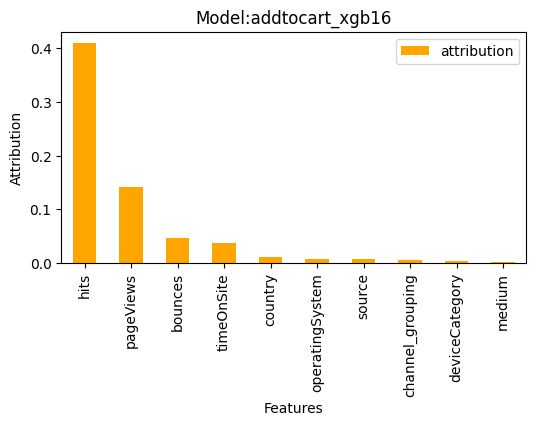

In [22]:
feature_attribution_df.plot.bar(x="feature", y="attribution", figsize = (6,3), color = "orange")
plt.title("Model:addtocart_xgb16")
plt.xlabel("Features")
plt.ylabel("Attribution")
plt.show()

In [23]:
%%bigquery df --project $PROJECT_ID

SELECT
  *
FROM
  ML.PREDICT(MODEL kavitha_capstone_dataset.addtocart_xgb16,
  (SELECT * EXCEPT(Id) FROM kavitha_capstone_dataset.ga_data WHERE data_split = "TEST" ))

Query is running:   0%|          |

Downloading:   0%|          |

In [24]:
results_df = test_metrics(df)

Accuracy : 0.9493
Precision : 0.6974
Recall : 0.4753
Confusion Matrix : 
[[5888   92]
 [ 234  212]]


In [25]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE MODEL kavitha_capstone_dataset.addtocart_xgb15

OPTIONS(
  MODEL_TYPE="LOGISTIC_REG",
  # Declare label column.
  INPUT_LABEL_COLS=["will_add_to_cart"],
# Enable Vertex Explainable AI aggregated feature attributions.
  ENABLE_GLOBAL_EXPLAIN=True,
  MODEL_REGISTRY="VERTEX_AI"
) AS

SELECT
    channel_grouping, hits, timeOnSite, pageViews, operatingSystem, country, will_add_to_cart
FROM
  kavitha_capstone_dataset.ga_data
WHERE 
    data_split = "TRAIN"

Query is running:   0%|          |

""


In [26]:
%%bigquery --project $PROJECT_ID

SELECT
  *
FROM
  ML.EVALUATE(MODEL kavitha_capstone_dataset.addtocart_xgb15)

Query is running:   0%|          |

Downloading:   0%|          |

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.724057,0.403947,0.942529,0.518581,0.159882,0.938353


In [27]:
%%bigquery --project $PROJECT_ID

SELECT
  expected_label,
    _0 AS predicted_0,
      _1 AS predicted_1
      
FROM
  ML.CONFUSION_MATRIX(MODEL kavitha_capstone_dataset.addtocart_xgb15) 

Query is running:   0%|          |

Downloading:   0%|          |

,expected_label,predicted_0,predicted_1
0,0,9041,117
1,1,453,307


In [28]:
%%bigquery --project $PROJECT_ID

SELECT
  *
FROM
  ML.GLOBAL_EXPLAIN(MODEL kavitha_capstone_dataset.addtocart_xgb15)
ORDER BY
  attribution DESC;

Query is running:   0%|          |

Downloading:   0%|          |

,feature,attribution
0,country,0.805337
1,channel_grouping,0.804291
2,operatingSystem,0.802220
3,hits,0.428778
4,pageViews,0.377067
5,timeOnSite,0.088520


In [29]:
%%bigquery df --project $PROJECT_ID

SELECT
  *
FROM
  ML.PREDICT(MODEL kavitha_capstone_dataset.addtocart_xgb15,
  (SELECT
    channel_grouping, hits, timeOnSite, pageViews, operatingSystem, bounces, source,medium, country, hasSocialSourceReferral,data_split, will_add_to_cart
FROM
  kavitha_capstone_dataset.ga_data WHERE data_split = "TEST"))

Query is running:   0%|          |

Downloading:   0%|          |

In [31]:
test_metrics(df)

Accuracy : 0.9483
Precision : 0.7436
Recall : 0.3901
Confusion Matrix : 
[[5920   60]
 [ 272  174]]


In [32]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE MODEL kavitha_capstone_dataset.addtocart_xgb13

OPTIONS(
  MODEL_TYPE="LOGISTIC_REG",
  AUTO_CLASS_WEIGHTS=TRUE,  
  # Declare label column.
  INPUT_LABEL_COLS=["will_add_to_cart"],
  # Specify custom data splitting using the `data_split` column.
  DATA_SPLIT_METHOD="NO_SPLIT",
  MODEL_REGISTRY="VERTEX_AI"
) AS

SELECT
    channel_grouping, hits, timeOnSite, pageViews, operatingSystem, country, will_add_to_cart
FROM
  kavitha_capstone_dataset.ga_data
WHERE 
    data_split = "TRAIN"

Query is running:   0%|          |

""


In [33]:
%%bigquery --project $PROJECT_ID

SELECT
  *
FROM
  ML.EVALUATE(MODEL kavitha_capstone_dataset.addtocart_xgb13)

Query is running:   0%|          |

Downloading:   0%|          |

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.411548,0.823933,0.898273,0.548917,0.365603,0.946312


In [35]:
%%bigquery --project $PROJECT_ID

SELECT
  expected_label,    
      _0 AS predicted_0,
    _1 AS predicted_1,
FROM
  ML.CONFUSION_MATRIX(MODEL kavitha_capstone_dataset.addtocart_xgb13) 

Query is running:   0%|          |

Downloading:   0%|          |

,expected_label,predicted_0,predicted_1
0,0,43822,4637
1,1,693,3243


In [36]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE MODEL kavitha_capstone_dataset.addtocart_xgb8

OPTIONS(
  MODEL_TYPE="LOGISTIC_REG",
  # Declare label column
  INPUT_LABEL_COLS=["will_add_to_cart"],
  MODEL_REGISTRY="VERTEX_AI"
) AS

SELECT
    bounces, timeOnSite, browser, country, socialNetwork, will_add_to_cart
FROM
  kavitha_capstone_dataset.ga_data

Query is running:   0%|          |

""


In [37]:
%%bigquery --project $PROJECT_ID

SELECT
  *
FROM
  ML.EVALUATE(MODEL kavitha_capstone_dataset.addtocart_xgb8)

Query is running:   0%|          |

Downloading:   0%|          |

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.57346,0.161549,0.928699,0.252083,0.189775,0.896545


In [38]:
%%bigquery --project $PROJECT_ID

SELECT
  expected_label,
      _1 AS predicted_1,
      _0 AS predicted_0
FROM
  ML.CONFUSION_MATRIX(MODEL kavitha_capstone_dataset.addtocart_xgb8) ORDER BY expected_label DESC


Query is running:   0%|          |

Downloading:   0%|          |

,expected_label,predicted_1,predicted_0
0,1,121,628
1,0,90,9231


In [39]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE MODEL kavitha_capstone_dataset.addtocart_xgb9

OPTIONS(
  MODEL_TYPE="LOGISTIC_REG",
  # Declare label column.
  INPUT_LABEL_COLS=["will_add_to_cart"],
  MODEL_REGISTRY="VERTEX_AI"
) AS

SELECT
    bounces, source,medium, country, hasSocialSourceReferral, will_add_to_cart
FROM
  kavitha_capstone_dataset.ga_data

Query is running:   0%|          |

""


In [40]:
%%bigquery --project $PROJECT_ID

SELECT
  *
FROM
  ML.EVALUATE(MODEL kavitha_capstone_dataset.addtocart_xgb9)

Query is running:   0%|          |

Downloading:   0%|          |

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.0,0.0,0.924557,0.0,0.218864,0.774226


In [41]:
%%bigquery --project $PROJECT_ID

SELECT
  expected_label,
    _0 AS predicted_0,
    _1 AS predicted_1
      
FROM
  ML.CONFUSION_MATRIX(MODEL kavitha_capstone_dataset.addtocart_xgb9) 


Query is running:   0%|          |

Downloading:   0%|          |

,expected_label,predicted_0,predicted_1
0,0,9179,2
1,1,747,0


In [49]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE MODEL kavitha_capstone_dataset.addtocart_xgb10

OPTIONS(
  MODEL_TYPE="LOGISTIC_REG",
  AUTO_CLASS_WEIGHTS=TRUE,  
  # Declare label column.
  INPUT_LABEL_COLS=["will_add_to_cart"],
  # Specify custom data splitting using the `data_split` column.
  DATA_SPLIT_METHOD="NO_SPLIT",
  #DATA_SPLIT_COL="data_split",
  MODEL_REGISTRY="VERTEX_AI"
) AS

SELECT
    channel_grouping, hits, timeOnSite, pageViews, operatingSystem, bounces, source,medium, country, hasSocialSourceReferral, will_add_to_cart 
FROM
  kavitha_capstone_dataset.ga_data 
    WHERE data_split = "TRAIN"

Query is running:   0%|          |

""


In [50]:
%%bigquery --project $PROJECT_ID

SELECT
  *
FROM
  ML.EVALUATE(MODEL kavitha_capstone_dataset.addtocart_xgb10)

Query is running:   0%|          |

Downloading:   0%|          |

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.394563,0.833333,0.891421,0.535554,0.337965,0.946646


In [51]:
%%bigquery --project $PROJECT_ID

SELECT
  expected_label,
    _0 AS predicted_0,
    _1 AS predicted_1
      
FROM
  ML.CONFUSION_MATRIX(MODEL kavitha_capstone_dataset.addtocart_xgb10) 


Query is running:   0%|          |

Downloading:   0%|          |

,expected_label,predicted_0,predicted_1
0,0,43426,5033
1,1,656,3280


In [52]:
%%bigquery df_roc --project $PROJECT_ID

SELECT * FROM ML.ROC_CURVE(MODEL kavitha_capstone_dataset.addtocart_xgb10)

Query is running:   0%|          |

Downloading:   0%|          |

<Axes: title={'center': 'AUC-ROC curve'}, xlabel='false_positive_rate'>

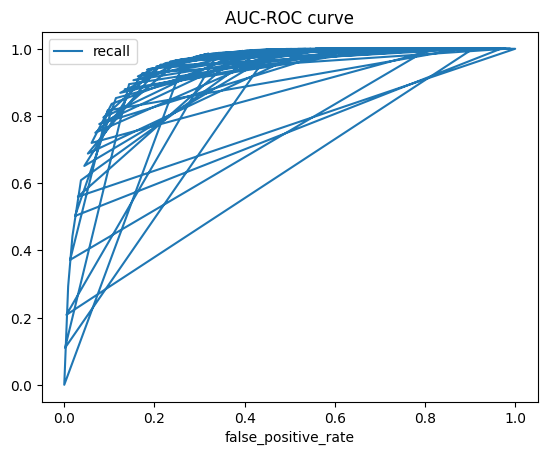

In [53]:
df_roc.plot(x="false_positive_rate", y="recall", title="AUC-ROC curve")

In [54]:
%%bigquery xgb5_df --project $PROJECT_ID

SELECT
  *
FROM
  ML.PREDICT(MODEL kavitha_capstone_dataset.addtocart_xgb10,
  (SELECT
    channel_grouping, hits, timeOnSite, pageViews, operatingSystem, bounces, source,medium, country, hasSocialSourceReferral, will_add_to_cart
FROM
  kavitha_capstone_dataset.ga_data WHERE data_split = "TEST"))

Query is running:   0%|          |

Downloading:   0%|          |

In [55]:
%%bigquery --project $PROJECT_ID

SELECT
  *
FROM
  ML.EVALUATE(MODEL kavitha_capstone_dataset.addtocart_xgb10)

Query is running:   0%|          |

Downloading:   0%|          |

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.394563,0.833333,0.891421,0.535554,0.337965,0.946646


In [56]:
MODEL_NAME="addtocart_xgb16"

In [109]:
BQ_MODEL = f"{BQ_DATASET}.{MODEL_NAME}"
BQ_MODEL_EXPORT_DIR = f"gs://{GCS_BUCKET}/{MODEL_NAME}"

In [110]:
print(BQ_MODEL)
print(BQ_MODEL_EXPORT_DIR )

york-bb-cohort:kavitha_capstone_dataset.addtocart_xgb16
gs://york-bb-cohort-kavi_capstone_bucket/addtocart_xgb16


In [111]:
!bq --location=$BQ_LOCATION extract \
--destination_format ML_XGBOOST_BOOSTER \
--model $BQ_MODEL \
$BQ_MODEL_EXPORT_DIR

Waiting on bqjob_r72cdb3a772ae593b_0000018dc3e9c202_1 ... (3s) Current status: DONE   


In [112]:
IMAGE_URI='us-docker.pkg.dev/vertex-ai/prediction/xgboost-cpu.1-4:latest'

In [113]:
model = vertexai.Model.upload(
    display_name=MODEL_NAME,
    artifact_uri=BQ_MODEL_EXPORT_DIR,
    serving_container_image_uri=IMAGE_URI,
)

Creating Model
Create Model backing LRO: projects/319407066227/locations/us-east4/models/7154997150961631232/operations/1799422247111229440
Model created. Resource name: projects/319407066227/locations/us-east4/models/7154997150961631232@1
To use this Model in another session:
model = aiplatform.Model('projects/319407066227/locations/us-east4/models/7154997150961631232@1')


In [ ]:
#model = aiplatform.Model('projects/319407066227/locations/us-east4/models/7154997150961631232@1')

In [114]:
endpoint = model.deploy(
    traffic_split={"0": 100},
    machine_type="e2-standard-2",
)

Creating Endpoint
Create Endpoint backing LRO: projects/319407066227/locations/us-east4/endpoints/3987189802129686528/operations/493378355173785600
Endpoint created. Resource name: projects/319407066227/locations/us-east4/endpoints/3987189802129686528
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/319407066227/locations/us-east4/endpoints/3987189802129686528')
Deploying model to Endpoint : projects/319407066227/locations/us-east4/endpoints/3987189802129686528
Deploy Endpoint model backing LRO: projects/319407066227/locations/us-east4/endpoints/3987189802129686528/operations/3285610124143493120
Endpoint model deployed. Resource name: projects/319407066227/locations/us-east4/endpoints/3987189802129686528


In [61]:
CATEGORICAL_FEATURES = ['channel_grouping',
                        'operatingSystem',
                        'deviceCategory',
                        'source',
                        'medium',
                        'country'
                       ]

In [62]:
from sklearn.preprocessing import OrdinalEncoder

In [63]:
def _build_cat_feature_encoders(cat_feature_list, gcs_bucket, model_name, na_value='Unknown'): 
    feature_encoders = {}
    
    for idx, feature in enumerate(cat_feature_list):
        feature_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
        feature_vocab_file = f"gs://{gcs_bucket}/{model_name}/assets/{idx}_categorical_label.txt"
        feature_vocab_df = pd.read_csv(feature_vocab_file, delimiter = "\t", header=None).fillna(na_value)
        feature_encoder.fit(feature_vocab_df.values)
        feature_encoders[feature] = feature_encoder
    
    return feature_encoders

In [64]:
def preprocess_xgboost(instances, cat_feature_list, feature_encoders):
    transformed_instances = []
    
    for instance in instances:
        for feature in cat_feature_list:
            feature_int = feature_encoders[feature].transform([[instance[feature]]]).item()
            instance[feature] = feature_int
            instance_list = list(instance.values())
        transformed_instances.append(instance_list)

    return transformed_instances

In [65]:
# Build a dictionary of ordinal categorical feature encoders.
feature_encoders = _build_cat_feature_encoders(CATEGORICAL_FEATURES, GCS_BUCKET, MODEL_NAME)

In [66]:
%%bigquery test_df --project $PROJECT_ID 

SELECT* EXCEPT (Id, will_add_to_cart, data_split, hasSocialSourceReferral, socialNetwork, browser)
FROM kavitha_capstone_dataset.ga_data
WHERE data_split="TEST"
LIMIT 12;

Query is running:   0%|          |

Downloading:   0%|          |

In [67]:
print(test_df)

  channel_grouping operatingSystem deviceCategory  source   medium  \
0   Organic Search         Windows        desktop  google  organic   
1   Organic Search         Android         mobile  google  organic   
2   Organic Search         Windows        desktop  google  organic   
3      Paid Search         Android         mobile  google      cpc   
4      Paid Search             iOS         mobile  google      cpc   

         country  hits  bounces  pageViews  timeOnSite  
0       Bulgaria    18        0         12          95  
1  United States    29        0         26        1789  
2         Turkey     2        0          2          22  
3  United States     2        0          2           7  
4  United States     2        0          2         121  


In [68]:
# Convert dataframe records to feature dictionaries for preprocessing by feature name.
test_instances = test_df.astype(str).to_dict(orient='records')

In [69]:
# Apply preprocessing to transform categorical features and return numerical instances for prediction.
transformed_test_instances = preprocess_xgboost(test_instances, CATEGORICAL_FEATURES, feature_encoders)

In [ ]:
# Generate predictions from model deployed to Vertex AI Endpoint.
predictions = endpoint.predict(instances=transformed_test_instances)

In [153]:
for idx, prediction in enumerate(predictions.predictions):
    # Class labels [1,0] retrieved from model_metadata.json in GCS model dir.
    # BQML binary classification default is 0.5 with above "Churn" and below "Not Churn".
    is_add_to_cart = "Added To Cart" if prediction[0] >= 0.5 else "Did Not Add To Cart"
    print(f"Prediction: Visitor {idx} - {is_add_to_cart} {prediction}")
    print(test_df.iloc[idx].astype(str).to_json() + "\n")

Prediction: Visitor 0 - Did Not Add To Cart [0.06581871956586838, 0.934181272983551]
{"channel_grouping":"Direct","operatingSystem":"Macintosh","deviceCategory":"desktop","source":"(direct)","medium":"(none)","country":"Germany","hits":"1","bounces":"1","pageViews":"1","timeOnSite":"0"}

Prediction: Visitor 1 - Did Not Add To Cart [0.06581871956586838, 0.934181272983551]
{"channel_grouping":"Direct","operatingSystem":"Linux","deviceCategory":"desktop","source":"(direct)","medium":"(none)","country":"United States","hits":"1","bounces":"1","pageViews":"1","timeOnSite":"0"}

Prediction: Visitor 2 - Did Not Add To Cart [0.06581871956586838, 0.934181272983551]
{"channel_grouping":"Organic Search","operatingSystem":"Macintosh","deviceCategory":"desktop","source":"google","medium":"organic","country":"Belgium","hits":"1","bounces":"1","pageViews":"1","timeOnSite":"0"}

Prediction: Visitor 3 - Did Not Add To Cart [0.06581871956586838, 0.934181272983551]
{"channel_grouping":"Organic Search","o